# Modelling fluid flows

- Importing modules

In [1]:
# !pip install -r ../requirements.txt

In [1]:
import pysindy as ps
import pydmd as pdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn

## Data Visualization

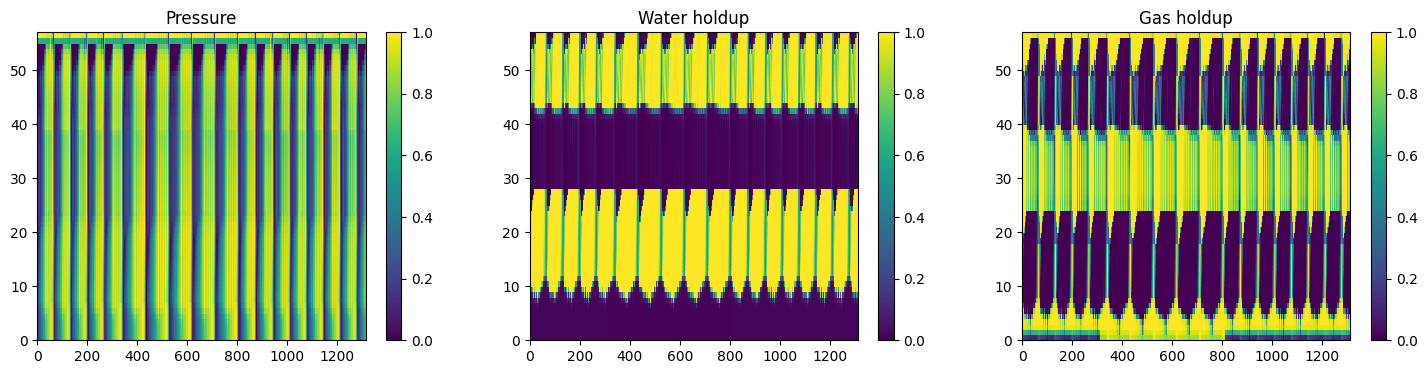

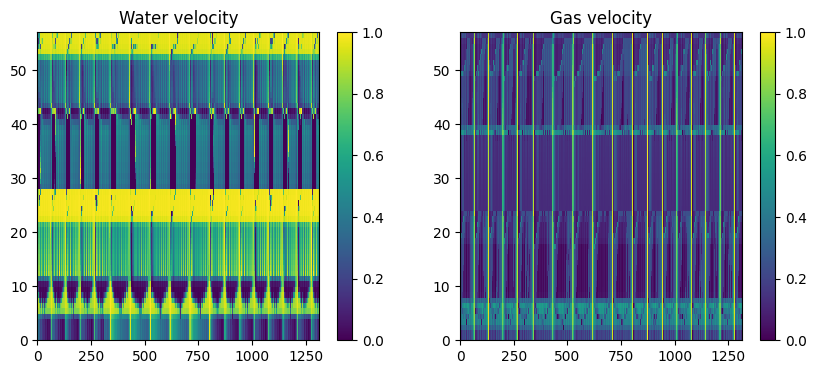

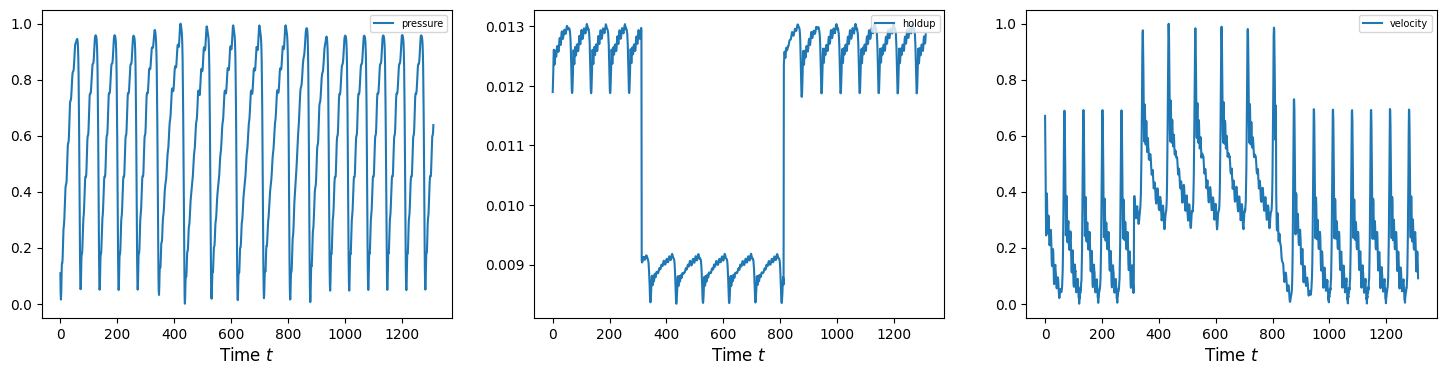

In [2]:


path = r'../data/'
df0 = pd.read_csv(path + 'pressure.csv', index_col=False, header=None)

df1 = pd.read_csv(path + 'water_holdup.csv', index_col=False, header=None)

df2 = pd.read_csv(path + 'water_velocity.csv', index_col=False, header=None)

df3 = pd.read_csv(path + 'gas_holdup.csv', index_col=False, header=None)

df4 = pd.read_csv(path + 'gas_velocity.csv', index_col=False, header=None)

df5 = pd.read_csv(path + 'x.csv', index_col=False, header=None)

df6 = pd.read_csv(path + 't.csv', index_col=False, header=None)

t_start = 0 

x_end = 57

x = df5.iloc[:x_end,0].to_numpy()

t = df6.iloc[t_start:,0].T.to_numpy()

pressure = df0.iloc[t_start:,:x_end].to_numpy().T

water_holdup = df1.iloc[t_start:,:x_end].to_numpy().T

water_velocity = df2.iloc[t_start:,:x_end].to_numpy().T

gas_holdup = df3.iloc[t_start:,:x_end].to_numpy().T

gas_velocity = df4.iloc[t_start:,:x_end].to_numpy().T

L = x[-1] # length of spatial domain
N = len(x) # number of spatial points in [0,L]

T = t[-1] # total time
Nt = len(t) # number of temporal points in [0,T]
#Input data

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.title("Pressure")
plt.pcolor(pressure)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Water holdup")
plt.pcolor(water_holdup)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Gas holdup")
plt.pcolor(gas_holdup)
plt.colorbar()
plt.show()
#Output data

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)

plt.subplot(1, 2, 1)
plt.title("Water velocity")
plt.pcolor(water_velocity)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Gas velocity")
plt.pcolor(gas_velocity)
plt.colorbar()
plt.show()

x_location = 0

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.plot(pressure.T[:,x_location],'-',label='pressure')
plt.xlabel('Time $t$', fontsize=12)
plt.legend(loc = 1, fontsize = 7)

plt.subplot(1, 3, 2)
plt.plot(water_holdup.T[:,x_location],'-',label='holdup')
plt.xlabel('Time $t$', fontsize=12)
plt.legend(loc = 1, fontsize = 7)

plt.subplot(1, 3, 3)
plt.plot(water_velocity.T[:,x_location],'-',label='velocity')
plt.xlabel('Time $t$', fontsize=12)
plt.legend(loc = 1, fontsize = 7)

plt.show()

## Building the data matrix

In [3]:
# stack the matrices of pressure, water holdup, and gas holdup
P_wh_ph = np.vstack((pressure, water_holdup, gas_holdup))

# stack the matrices of water velocity, gas velocity
v_w_g = np.vstack((water_velocity, gas_velocity))

# stack the matrices of pressure, water holdup, gas holdup, water velocity, gas velocity,
P_wh_ph_v_w_g = np.vstack((P_wh_ph, v_w_g))

# print the shape of the each matrix :
print(f"Shape of P_wh_ph: {P_wh_ph.shape}\nShape of v_w_g: {v_w_g.shape}\nShape of P_wh_ph_v_w_g: {P_wh_ph_v_w_g.shape}")

Shape of P_wh_ph: (171, 1313)
Shape of v_w_g: (114, 1313)
Shape of P_wh_ph_v_w_g: (285, 1313)


- Preprocessing using SKlearn 

In [4]:
# sklearn models split and feature scaling
scaler = sklearn.preprocessing.StandardScaler()
P_wh_ph_scaled = scaler.fit_transform(P_wh_ph)
v_w_g_scaled = scaler.fit_transform(v_w_g)
P_wh_ph_v_w_g_scaled = scaler.fit_transform(P_wh_ph_v_w_g)


## pydmd and pysindy modelling

In [5]:
import pydmd 
# print all the functions in pydmd
print(dir(pydmd))

['BOPDMD', 'CDMD', 'DMD', 'DMDBase', 'DMDc', 'EDMD', 'FbDMD', 'HAVOK', 'HODMD', 'HankelDMD', 'LANDO', 'ModesTuner', 'MrDMD', 'OptDMD', 'ParametricDMD', 'PiDMD', 'PrePostProcessingDMD', 'RDMD', 'SpDMD', 'SubspaceDMD', 'VarProDMD', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'bopdmd', 'cdmd', 'dmd', 'dmd_modes_tuner', 'dmdbase', 'dmdc', 'dmdoperator', 'edmd', 'fbdmd', 'hankeldmd', 'havok', 'hodmd', 'lando', 'mrdmd', 'optdmd', 'paramdmd', 'pidmd', 'pidmd_utils', 'preprocessing', 'rdmd', 'snapshots', 'spdmd', 'subspacedmd', 'utils', 'varprodmd']


time training: 1050
time test: 263
time total: 1313
original shape: (1050, 285), reconstructed shape: (1050, 285)
timesteps: (1313,)
t_train: (1050,)
reconstructed_data: (1050, 1512)


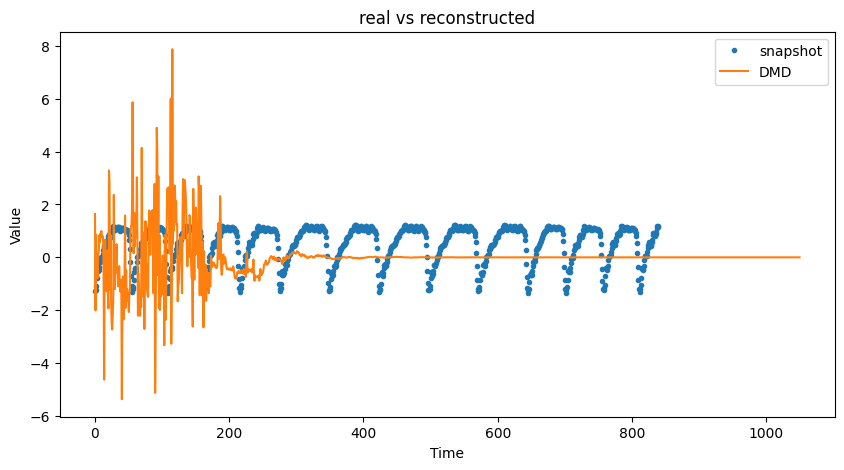

In [6]:
# modelling the pressure, water holdup, gas holdup, water velocity, gas velocity using pydmd and pysindy models 
import pydmd
from pydmd import DMD
from pydmd.hankeldmd import hankel_preprocessing
# functions = [DMD, HODMD, HODMDc, DMDc, BOPDMD, CDMD, DMDBase, EDMD, FbDMD, HankelDMD, RDMD]
import matplotlib.pyplot as plt
import numpy as np
min_shape = min(P_wh_ph_v_w_g_scaled.shape[0],P_wh_ph_v_w_g_scaled.shape[1])
N_scale = 0.8
m = int(Nt*N_scale)
print(f"time training: {m}")
print(f"time test: {len(t)-m}")
print(f"time total: {len(t)}")
P_wh_ph_v_w_g_train = P_wh_ph_v_w_g_scaled[:,:m]
P_wh_ph_v_w_g_test = P_wh_ph_v_w_g_scaled[:,m:]
t_train = t[:m]
x_location = 10
d = 200
dmd = DMD(svd_rank=d)
delay_dmd = pydmd.preprocessing.hankel_preprocessing(dmd, d=d)
delay_dmd.fit(P_wh_ph_v_w_g_train.T)

original = P_wh_ph_v_w_g_train.T

reconstructed = delay_dmd.reconstructed_data.real
delay_dmd.dmd_time["dt"] = np.mean(t[1:])-np.mean(t[:-1])
delay_dmd.dmd_time["t0"] = t[0]
delay_dmd.dmd_time["tend"] = t[-1]
print(f"original shape: {original.shape}, reconstructed shape: {reconstructed.shape}")
print(f"timesteps: {delay_dmd.dmd_timesteps.shape}")
print(f"t_train: {t_train.shape}")
print(f"reconstructed_data: {delay_dmd.reconstructed_data.shape}")


plt.figure(figsize = (10,5))
plt.plot(t_train, P_wh_ph_v_w_g_train[x_location,:],'.',label='snapshot')
plt.plot(delay_dmd.dmd_timesteps[:], delay_dmd.reconstructed_data[x_location,:len(t)].real, label="DMD")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title(f"real vs reconstructed")
plt.show()


# plt.figure(figsize=(20, 7))

# plt.subplot(1, 3, 1)
# eigs = delay_dmd.eigs
# plt.scatter(eigs.real, eigs.imag, marker='o', color='b')
# plt.xlabel('Real')
# plt.ylabel('Imaginary')
# plt.title(f'DMD Eigenvalues for d = {d}')
# plt.grid(True)
# plt.axhline(0, color='black', linewidth=0.5)
# plt.axvline(0, color='black', linewidth=0.5)

# # plt.subplot(1, 4, 2)
# # plt.plot(np.abs(delay_dmd.modes[:, 0]))
# # plt.title('First DMD Mode (abs)')
# # plt.xlabel('Index')
# # plt.ylabel('Amplitude')

# plt.subplot(1, 3, 2)
# plt.imshow(reconstructed.T, aspect='auto', cmap='viridis', origin='lower')
# plt.title(f'Reconstructed for d = {d}')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.colorbar()

# plt.subplot(1, 3, 3)
# plt.imshow(original.T, aspect='auto', cmap='viridis', origin='lower')
# plt.title('Original (2D)')
# plt.xlabel('Time')
# plt.ylabel('Index')
# plt.colorbar()

# plt.tight_layout()
# plt.show()
# plt.figure(figsize=(8,6))
# plt.plot(t_train, P_wh_ph_v_w_g_train[x_location,:m],'-',label='function')
# plt.plot(t_train, P_wh_ph_v_w_g_train[x_location,:],'.',label='snapshot')
# plt.plot(delay_dmd.dmd_timesteps, delay_dmd.reconstructed_data[x_location,:].real,'--',label ='DMD')
# plt.xlabel("Time")
# plt.ylabel("Value")
# plt.legend()
# plt.show()

    






In [7]:
# import matplotlib.pyplot as plt
# import numpy as np

# from pydmd import DMD, HODMD, MrDMD

# from pydmd.plotter import plot_eigs, plot_eigs_mrdmd

# # Seed the random number generators
# np.random.seed(1)
# def f1(x, t, amplitude, coeff_x, coeff_t):
#     delay_x = coeff_x*t
#     delay_t = coeff_t*x
#     return amplitude*(np.sin(0.7*(x+delay_x))*(np.cos(0.2*(t+delay_t)) - np.sin(0.1*(t+delay_t))))
# x_location = 10
# #Number of x points
# n = 150
# x = np.linspace(1, n, n)

# #Number of time points
# k = 300
# t = np.linspace(1, k, k)

# #Number of train points in t
# m = 250
# t_train = t[:m]

# Tm, Xm = np.meshgrid(t, x)

# Full_function = f1(Xm, Tm, 1, 0.1, -0.3)
# snapshots = Full_function[:,:m]
# #DMD 
# DMD_rank = 8 

# dmd = DMD(svd_rank = DMD_rank)
# dmd.fit(snapshots)

# hoDMD_rank = 8

# hodmd = HODMD(svd_rank = hoDMD_rank)
# hodmd.fit(snapshots)

# sub_dmd = DMD(svd_rank=8)

# mrdmd = MrDMD(sub_dmd, max_level=3, max_cycles=5)
# mrdmd.fit(snapshots)
# plot_eigs(dmd)
# plot_eigs(hodmd)
# plot_eigs_mrdmd(mrdmd)
# plt.figure(figsize=(16, 6))

# plt.subplot(121)
# plt.title("Snapshot data")
# plt.pcolor(t_train, x, snapshots.real)
# plt.colorbar()

# plt.subplot(122)
# plt.title("Reconstructed by DMD")
# plt.pcolor(t_train, x, dmd.reconstructed_data.real)
# plt.colorbar()

# plt.show()

# plt.figure(figsize=(16, 6))

# plt.subplot(121)
# plt.title("Snapshot data")
# plt.pcolor(t_train, x, snapshots.real)
# plt.colorbar()

# plt.subplot(122)
# plt.title("Reconstructed by hoDMD")
# plt.pcolor(t_train, x, hodmd.reconstructed_data.real)
# plt.colorbar()

# plt.show()

# plt.figure(figsize=(16, 6))

# plt.subplot(121)
# plt.title("Snapshot data")
# plt.pcolor(t_train, x, snapshots.real)
# plt.colorbar()

# plt.subplot(122)
# plt.title("Reconstructed by mrDMD")
# plt.pcolor(t_train, x, mrdmd.reconstructed_data.real)
# plt.colorbar()

# plt.show()
# #DMD training results as a function of time

# plt.figure(figsize=(8,6))
# plt.plot(t_train, Full_function[x_location,:m],'-',label='function')
# plt.plot(t_train, snapshots[x_location,:],'.',label='snapshot')
# plt.plot(dmd.dmd_timesteps, dmd.reconstructed_data[x_location,:].real,'--',label ='DMD')
# plt.plot(hodmd.dmd_timesteps, hodmd.reconstructed_data[x_location,:].real,'--',label ='hoDMD')
# plt.plot(mrdmd.dmd_timesteps[:-1], mrdmd.reconstructed_data[x_location,:].real,'--',label ='mrDMD')
# plt.xlabel("Time")
# plt.ylabel("Value")
# plt.legend()
# plt.show()
# #DMD prediction for spatiotemporal data

# dmd.dmd_time["dt"] = t[1] - t[0]
# dmd.dmd_time["t0"] = t[0]
# dmd.dmd_time["tend"] = t[-1]

# hodmd.dmd_time["dt"] = t[1] - t[0]
# hodmd.dmd_time["t0"] = t[0]
# hodmd.dmd_time["tend"] = t[-1]

# plt.figure(figsize=(10, 6))

# plt.subplot(131)
# plt.title("Original system for prediction interval")
# plt.pcolor(t[m:], x, Full_function[:,m:].real)

# plt.subplot(132)
# plt.title("Predicted by DMD")
# plt.pcolor(t[m:], x, dmd.reconstructed_data[:,m:].real)

# plt.subplot(133)
# plt.title("Predicted by hoDMD")
# plt.pcolor(t[m:], x, hodmd.reconstructed_data[:,m:].real)

# plt.show()
# #DMD prediction as a function of time 

# plt.figure(figsize=(8,6))
# plt.plot(t, Full_function[x_location,:],'-',label='function')
# plt.plot(t_train, snapshots[x_location,:],'.',label='snapshot')
# plt.plot(dmd.dmd_timesteps[m:], dmd.reconstructed_data[x_location,m:].real,'--',label ='DMD')
# plt.plot(hodmd.dmd_timesteps[m:], hodmd.reconstructed_data[x_location,m:].real,'--',label ='hoDMD')
# plt.xlabel("Time")
# plt.ylabel("Value")
# plt.legend()
# plt.show()


In [7]:
"""
Velocity Modeling Module

This module provides comprehensive modeling approaches for water and gas velocity
using PyDMD, PySINDy, and machine learning techniques.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import pydmd as pdm
from pydmd import DMD, HODMD, DMDc
import pysindy as ps
from pysindy import SINDy
import warnings
warnings.filterwarnings('ignore')


class VelocityModeler:
    """
    Comprehensive velocity modeling class using multiple approaches.
    """
    
    def __init__(self, data_path='../data/'):
        """
        Initialize the velocity modeler.
        
        Parameters:
        -----------
        data_path : str
            Path to the data directory
        """
        self.data_path = data_path
        self.data = {}
        self.models = {}
        self.scalers = {}
        self.results = {}
        
    def load_data(self):
        """Load all velocity and related data."""
        try:
            # Load all data files
            self.data['pressure'] = pd.read_csv(self.data_path + 'pressure.csv', 
                                               index_col=False, header=None).to_numpy().T
            self.data['water_holdup'] = pd.read_csv(self.data_path + 'water_holdup.csv', 
                                                   index_col=False, header=None).to_numpy().T
            self.data['water_velocity'] = pd.read_csv(self.data_path + 'water_velocity.csv', 
                                                     index_col=False, header=None).to_numpy().T
            self.data['gas_holdup'] = pd.read_csv(self.data_path + 'gas_holdup.csv', 
                                                 index_col=False, header=None).to_numpy().T
            self.data['gas_velocity'] = pd.read_csv(self.data_path + 'gas_velocity.csv', 
                                                   index_col=False, header=None).to_numpy().T
            self.data['x_coords'] = pd.read_csv(self.data_path + 'x.csv', 
                                               index_col=False, header=None).iloc[:,0].to_numpy()
            self.data['t_coords'] = pd.read_csv(self.data_path + 't.csv', 
                                               index_col=False, header=None).iloc[:,0].to_numpy()
            
            print("Data loaded successfully!")
            print(f"Spatial points: {len(self.data['x_coords'])}")
            print(f"Time points: {len(self.data['t_coords'])}")
            
        except Exception as e:
            print(f"Error loading data: {e}")
            
    def prepare_dmd_data(self, train_ratio=0.8):
        """Prepare data for DMD modeling."""
        # Combine water and gas velocity
        velocity_data = np.vstack((self.data['water_velocity'], self.data['gas_velocity']))
        
        # Split into training and testing
        n_train = int(velocity_data.shape[1] * train_ratio)
        
        self.dmd_data = {
            'train': velocity_data[:, :n_train],
            'test': velocity_data[:, n_train:],
            't_train': self.data['t_coords'][:n_train],
            't_test': self.data['t_coords'][n_train:],
            'full': velocity_data
        }
        
        return self.dmd_data
    
    def fit_dmd(self, rank=20, dmd_type='standard'):
        """
        Fit DMD model.
        
        Parameters:
        -----------
        rank : int
            SVD rank for DMD
        dmd_type : str
            Type of DMD ('standard', 'hodmd', 'dmdc')
        """
        if dmd_type == 'standard':
            dmd = DMD(svd_rank=rank)
        elif dmd_type == 'hodmd':
            dmd = HODMD(svd_rank=rank)
        elif dmd_type == 'dmdc':
            # For DMDc, we need control inputs
            dmd = DMDc(svd_rank=rank)
        else:
            raise ValueError(f"Unknown DMD type: {dmd_type}")
        
        # Fit the model
        dmd.fit(self.dmd_data['train'])
        
        # Set time parameters
        dt = self.data['t_coords'][1] - self.data['t_coords'][0]
        dmd.dmd_time['dt'] = dt
        dmd.dmd_time['t0'] = self.data['t_coords'][0]
        dmd.dmd_time['tend'] = self.data['t_coords'][-1]
        
        self.models[f'dmd_{dmd_type}'] = dmd
        
        # Calculate reconstruction
        reconstructed = dmd.reconstructed_data.real
        
        # Calculate metrics
        train_error = np.mean((self.dmd_data['train'] - reconstructed[:, :len(self.dmd_data['t_train'])])**2)
        test_error = np.mean((self.dmd_data['test'] - reconstructed[:, len(self.dmd_data['t_train']):])**2)
        
        self.results[f'dmd_{dmd_type}'] = {
            'train_error': train_error,
            'test_error': test_error,
            'reconstructed': reconstructed,
            'eigenvalues': dmd.eigs,
            'modes': dmd.modes
        }
        
        return dmd
    
    def prepare_sindy_data(self, x_location=20, train_ratio=0.8):
        """Prepare data for SINDy modeling."""
        # Get time series at specific location
        water_vel_ts = self.data['water_velocity'][x_location, :]
        gas_vel_ts = self.data['gas_velocity'][x_location, :]
        pressure_ts = self.data['pressure'][x_location, :]
        water_holdup_ts = self.data['water_holdup'][x_location, :]
        gas_holdup_ts = self.data['gas_holdup'][x_location, :]
        
        # Stack all variables
        X = np.column_stack([water_vel_ts, gas_vel_ts, pressure_ts, water_holdup_ts, gas_holdup_ts])
        
        # Split into training and testing
        n_train = int(X.shape[0] * train_ratio)
        X_train = X[:n_train]
        X_test = X[n_train:]
        
        # Compute derivatives
        dt = self.data['t_coords'][1] - self.data['t_coords'][0]
        X_dot = np.gradient(X, dt, axis=0)
        X_dot_train = X_dot[:n_train]
        X_dot_test = X_dot[n_train:]
        
        self.sindy_data = {
            'X_train': X_train,
            'X_test': X_test,
            'X_dot_train': X_dot_train,
            'X_dot_test': X_dot_test,
            't_train': self.data['t_coords'][:n_train],
            't_test': self.data['t_coords'][n_train:],
            'x_location': x_location
        }
        
        return self.sindy_data
    
    def fit_sindy(self, threshold=0.1, degree=2):
        """
        Fit SINDy model.
        
        Parameters:
        -----------
        threshold : float
            Threshold for sparse regression
        degree : int
            Degree of polynomial features
        """
        feature_names = ['water_vel', 'gas_vel', 'pressure', 'water_holdup', 'gas_holdup']
        
        # Create SINDy model
        poly_library = ps.PolynomialLibrary(degree=degree)
        optimizer = ps.STLSQ(threshold=threshold)
        
        model = SINDy(
            feature_library=poly_library,
            optimizer=optimizer,
            feature_names=feature_names
        )
        
        # Fit the model
        model.fit(self.sindy_data['X_train'], t=self.sindy_data['t_train'], 
                 x_dot=self.sindy_data['X_dot_train'])
        
        self.models['sindy'] = model
        
        # Simulate the discovered system
        X_sim = model.simulate(self.sindy_data['X_train'][0], self.sindy_data['t_train'])
        
        # Calculate metrics
        mse_water = mean_squared_error(self.sindy_data['X_train'][:, 0], X_sim[:, 0])
        mse_gas = mean_squared_error(self.sindy_data['X_train'][:, 1], X_sim[:, 1])
        
        self.results['sindy'] = {
            'mse_water': mse_water,
            'mse_gas': mse_gas,
            'X_sim': X_sim,
            'model': model
        }
        
        return model
    
    def prepare_ml_data(self, include_spatiotemporal=True):
        """Prepare data for machine learning modeling."""
        if include_spatiotemporal:
            # Enhanced features with spatial gradients and temporal derivatives
            dx = self.data['x_coords'][1] - self.data['x_coords'][0]
            dt = self.data['t_coords'][1] - self.data['t_coords'][0]
            
            # Spatial gradients
            pressure_grad_x = np.gradient(self.data['pressure'], dx, axis=0)
            water_holdup_grad_x = np.gradient(self.data['water_holdup'], dx, axis=0)
            gas_holdup_grad_x = np.gradient(self.data['gas_holdup'], dx, axis=0)
            
            # Temporal derivatives
            pressure_dot = np.gradient(self.data['pressure'], dt, axis=1)
            water_holdup_dot = np.gradient(self.data['water_holdup'], dt, axis=1)
            gas_holdup_dot = np.gradient(self.data['gas_holdup'], dt, axis=1)
            
            features = np.column_stack([
                self.data['pressure'].flatten(),
                self.data['water_holdup'].flatten(),
                self.data['gas_holdup'].flatten(),
                pressure_grad_x.flatten(),
                water_holdup_grad_x.flatten(),
                gas_holdup_grad_x.flatten(),
                pressure_dot.flatten(),
                water_holdup_dot.flatten(),
                gas_holdup_dot.flatten()
            ])
        else:
            # Basic features
            features = np.column_stack([
                self.data['pressure'].flatten(),
                self.data['water_holdup'].flatten(),
                self.data['gas_holdup'].flatten()
            ])
        
        # Targets
        water_vel_target = self.data['water_velocity'].flatten()
        gas_vel_target = self.data['gas_velocity'].flatten()
        
        self.ml_data = {
            'features': features,
            'water_vel_target': water_vel_target,
            'gas_vel_target': gas_vel_target,
            'enhanced': include_spatiotemporal
        }
        
        return self.ml_data
    
    def fit_ml_models(self, test_size=0.2):
        """Fit machine learning models."""
        # Split data
        X_train, X_test, y_water_train, y_water_test = train_test_split(
            self.ml_data['features'], self.ml_data['water_vel_target'], 
            test_size=test_size, random_state=42
        )
        
        _, _, y_gas_train, y_gas_test = train_test_split(
            self.ml_data['features'], self.ml_data['gas_vel_target'], 
            test_size=test_size, random_state=42
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        self.scalers['ml'] = scaler
        
        # Train Random Forest models
        rf_water = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_gas = RandomForestRegressor(n_estimators=100, random_state=42)
        
        rf_water.fit(X_train_scaled, y_water_train)
        rf_gas.fit(X_train_scaled, y_gas_train)
        
        # Train Neural Network models
        nn_water = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
        nn_gas = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
        
        nn_water.fit(X_train_scaled, y_water_train)
        nn_gas.fit(X_train_scaled, y_gas_train)
        
        # Store models
        self.models['rf_water'] = rf_water
        self.models['rf_gas'] = rf_gas
        self.models['nn_water'] = nn_water
        self.models['nn_gas'] = nn_gas
        
        # Make predictions
        y_water_pred_rf = rf_water.predict(X_test_scaled)
        y_gas_pred_rf = rf_gas.predict(X_test_scaled)
        y_water_pred_nn = nn_water.predict(X_test_scaled)
        y_gas_pred_nn = nn_gas.predict(X_test_scaled)
        
        # Calculate metrics
        self.results['ml'] = {
            'rf_water': {
                'mse': mean_squared_error(y_water_test, y_water_pred_rf),
                'r2': r2_score(y_water_test, y_water_pred_rf),
                'predictions': y_water_pred_rf,
                'true': y_water_test
            },
            'rf_gas': {
                'mse': mean_squared_error(y_gas_test, y_gas_pred_rf),
                'r2': r2_score(y_gas_test, y_gas_pred_rf),
                'predictions': y_gas_pred_rf,
                'true': y_gas_test
            },
            'nn_water': {
                'mse': mean_squared_error(y_water_test, y_water_pred_nn),
                'r2': r2_score(y_water_test, y_water_pred_nn),
                'predictions': y_water_pred_nn,
                'true': y_water_test
            },
            'nn_gas': {
                'mse': mean_squared_error(y_gas_test, y_gas_pred_nn),
                'r2': r2_score(y_gas_test, y_gas_pred_nn),
                'predictions': y_gas_pred_nn,
                'true': y_gas_test
            }
        }
        
        return self.results['ml']
    
    def plot_results(self, save_path=None):
        """Plot comprehensive results."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # DMD results
        if 'dmd_standard' in self.results:
            dmd = self.models['dmd_standard']
            x_loc = 20
            
            axes[0,0].plot(self.dmd_data['t_train'], 
                          self.dmd_data['train'][x_loc, :], 'b-', label='True', linewidth=2)
            axes[0,0].plot(dmd.dmd_timesteps[:len(self.dmd_data['t_train'])], 
                          self.results['dmd_standard']['reconstructed'][x_loc, :len(self.dmd_data['t_train'])], 
                          'r--', label='DMD', linewidth=2)
            axes[0,0].set_title('DMD: Water Velocity')
            axes[0,0].legend()
        
        # SINDy results
        if 'sindy' in self.results:
            axes[0,1].plot(self.sindy_data['t_train'], 
                          self.sindy_data['X_train'][:, 0], 'b-', label='True', linewidth=2)
            axes[0,1].plot(self.sindy_data['t_train'], 
                          self.results['sindy']['X_sim'][:, 0], 'r--', label='SINDy', linewidth=2)
            axes[0,1].set_title('SINDy: Water Velocity')
            axes[0,1].legend()
        
        # ML results
        if 'ml' in self.results:
            n_plot = min(1000, len(self.results['ml']['rf_water']['true']))
            axes[0,2].scatter(self.results['ml']['rf_water']['true'][:n_plot], 
                             self.results['ml']['rf_water']['predictions'][:n_plot], 
                             alpha=0.6, label='RF', s=20)
            axes[0,2].scatter(self.results['ml']['nn_water']['true'][:n_plot], 
                             self.results['ml']['nn_water']['predictions'][:n_plot], 
                             alpha=0.6, label='NN', s=20)
            axes[0,2].plot([self.results['ml']['rf_water']['true'].min(), 
                           self.results['ml']['rf_water']['true'].max()], 
                          [self.results['ml']['rf_water']['true'].min(), 
                           self.results['ml']['rf_water']['true'].max()], 'k--', linewidth=2)
            axes[0,2].set_title('ML: Water Velocity Predictions')
            axes[0,2].legend()
        
        # Performance comparison
        models = []
        mses = []
        r2s = []
        
        if 'ml' in self.results:
            models.extend(['RF Water', 'RF Gas', 'NN Water', 'NN Gas'])
            mses.extend([
                self.results['ml']['rf_water']['mse'],
                self.results['ml']['rf_gas']['mse'],
                self.results['ml']['nn_water']['mse'],
                self.results['ml']['nn_gas']['mse']
            ])
            r2s.extend([
                self.results['ml']['rf_water']['r2'],
                self.results['ml']['rf_gas']['r2'],
                self.results['ml']['nn_water']['r2'],
                self.results['ml']['nn_gas']['r2']
            ])
        
        if models:
            axes[1,0].bar(models, mses, alpha=0.7)
            axes[1,0].set_title('Model Performance (MSE)')
            axes[1,0].tick_params(axis='x', rotation=45)
            
            axes[1,1].bar(models, r2s, alpha=0.7)
            axes[1,1].set_title('Model Performance (R²)')
            axes[1,1].tick_params(axis='x', rotation=45)
        
        # Feature importance (if available)
        if 'rf_water' in self.models:
            feature_names = ['P', 'WH', 'GH', 'P_x', 'WH_x', 'GH_x', 'P_t', 'WH_t', 'GH_t'] if self.ml_data['enhanced'] else ['P', 'WH', 'GH']
            importance_water = self.models['rf_water'].feature_importances_
            importance_gas = self.models['rf_gas'].feature_importances_
            
            x_pos = np.arange(len(feature_names))
            width = 0.35
            
            axes[1,2].bar(x_pos - width/2, importance_water, width, label='Water', alpha=0.7)
            axes[1,2].bar(x_pos + width/2, importance_gas, width, label='Gas', alpha=0.7)
            axes[1,2].set_title('Feature Importance')
            axes[1,2].set_xticks(x_pos)
            axes[1,2].set_xticklabels(feature_names, rotation=45)
            axes[1,2].legend()
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def print_summary(self):
        """Print comprehensive summary of all results."""
        print("=" * 60)
        print("VELOCITY MODELING RESULTS SUMMARY")
        print("=" * 60)
        
        if 'dmd_standard' in self.results:
            print(f"\nDMD Results:")
            print(f"  Training MSE: {self.results['dmd_standard']['train_error']:.6f}")
            print(f"  Testing MSE: {self.results['dmd_standard']['test_error']:.6f}")
        
        if 'sindy' in self.results:
            print(f"\nSINDy Results:")
            print(f"  Water Velocity MSE: {self.results['sindy']['mse_water']:.6f}")
            print(f"  Gas Velocity MSE: {self.results['sindy']['mse_gas']:.6f}")
        
        if 'ml' in self.results:
            print(f"\nMachine Learning Results:")
            print(f"{'Model':<15} {'MSE':<12} {'R²':<8}")
            print("-" * 35)
            for model_name, results in self.results['ml'].items():
                print(f"{model_name:<15} {results['mse']:<12.6f} {results['r2']:<8.4f}")
        
        print("\n" + "=" * 60)


def run_comprehensive_analysis(data_path='../data/', save_results=True):
    """
    Run comprehensive velocity modeling analysis.
    
    Parameters:
    -----------
    data_path : str
        Path to data directory
    save_results : bool
        Whether to save plots
    """
    # Initialize modeler
    modeler = VelocityModeler(data_path)
    
    # Load data
    modeler.load_data()
    
    # DMD analysis
    print("Running DMD analysis...")
    modeler.prepare_dmd_data()
    modeler.fit_dmd(rank=20, dmd_type='standard')
    
    # SINDy analysis
    print("Running SINDy analysis...")
    modeler.prepare_sindy_data(x_location=20)
    modeler.fit_sindy(threshold=0.1, degree=2)
    
    # ML analysis
    print("Running Machine Learning analysis...")
    modeler.prepare_ml_data(include_spatiotemporal=True)
    modeler.fit_ml_models()
    
    # Plot results
    if save_results:
        modeler.plot_results(save_path='velocity_modeling_results.png')
    else:
        modeler.plot_results()
    
    # Print summary
    modeler.print_summary()
    
    return modeler


if __name__ == "__main__":
    # Run the comprehensive analysis
    modeler = run_comprehensive_analysis() 

Data loaded successfully!
Spatial points: 60
Time points: 1313
Running DMD analysis...
Running SINDy analysis...


ValueError: Input contains infinity or a value too large for dtype('float64').

In [8]:
#!/usr/bin/env python3
"""
Example script for velocity modeling using PyDMD, PySINDy, and Machine Learning.

This script demonstrates how to use the VelocityModeler class to analyze
water and gas velocity data using multiple modeling approaches.
"""

import sys
import os

# Add the src directory to the path
sys.path.append(os.path.join(os.path.dirname(__file__), 'src'))

from velocity_models import VelocityModeler, run_comprehensive_analysis

def main():
    """Main function to run velocity modeling analysis."""
    
    print("=" * 60)
    print("VELOCITY MODELING EXAMPLE")
    print("=" * 60)
    
    # Option 1: Run comprehensive analysis (recommended)
    print("\nRunning comprehensive analysis...")
    try:
        modeler = run_comprehensive_analysis(data_path='data/', save_results=True)
        print("Comprehensive analysis completed successfully!")
    except Exception as e:
        print(f"Error in comprehensive analysis: {e}")
        print("Trying step-by-step approach...")
        
        # Option 2: Step-by-step approach
        try:
            # Initialize modeler
            modeler = VelocityModeler(data_path='data/')
            
            # Load data
            print("\n1. Loading data...")
            modeler.load_data()
            
            # DMD analysis
            print("\n2. Running DMD analysis...")
            modeler.prepare_dmd_data()
            modeler.fit_dmd(rank=20, dmd_type='standard')
            
            # SINDy analysis
            print("\n3. Running SINDy analysis...")
            modeler.prepare_sindy_data(x_location=20)
            modeler.fit_sindy(threshold=0.1, degree=2)
            
            # ML analysis
            print("\n4. Running Machine Learning analysis...")
            modeler.prepare_ml_data(include_spatiotemporal=True)
            modeler.fit_ml_models()
            
            # Plot results
            print("\n5. Plotting results...")
            modeler.plot_results()
            
            # Print summary
            print("\n6. Printing summary...")
            modeler.print_summary()
            
            print("\nStep-by-step analysis completed successfully!")
            
        except Exception as e:
            print(f"Error in step-by-step analysis: {e}")
            print("Please check your data files and dependencies.")
            return
    
    print("\n" + "=" * 60)
    print("ANALYSIS COMPLETED")
    print("=" * 60)
    print("\nWhat was accomplished:")
    print("1. PyDMD: Analyzed spatiotemporal dynamics of velocity data")
    print("2. PySINDy: Discovered governing equations for the system")
    print("3. Machine Learning: Trained Random Forest and Neural Network models")
    print("4. Enhanced Features: Incorporated spatial gradients and temporal derivatives")
    print("5. Performance Comparison: Evaluated all models using MSE and R² metrics")
    print("6. Feature Importance: Analyzed which features are most important for predictions")
    
    print("\nFiles created:")
    print("- velocity_modeling_results.png: Comprehensive visualization of results")
    print("- notebook/velocity_modeling.ipynb: Detailed Jupyter notebook with analysis")
    print("- src/velocity_models.py: Reusable Python module for velocity modeling")

if __name__ == "__main__":
    main() 

NameError: name '__file__' is not defined